In [1]:
student_Name='Bobb Shields'
student_ID='wde677'
dataset_URL='https://www.kaggle.com/datasets/sheacon/tn-mvr-2018-2022'

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split


Noting changes made 4/4 due to mistakes in data prep.  "HINO" is a commercial truck manufacturer, so removed from imports category, pushing it into other.  And the sports mask was showing the imports group - corrected that typo.  

4/29 Update - Dropped commercial trucks and winnebagos that dont' fit the cars + trucks schema.  These were supposed to have been dropped in filtering down on type variable. Removed the max price on luxury vehicles.  Dropped non-luxury maximum to 250k.  Changes made in Data Prep notebook, iterated the filename to v3. 

Filters have been applied to reduce this to automobiles only, less than 500k miles, less than 100 years old, less than $10mil, 

Things need to be checked.  MERC and MERZ fixed in download but look for further duplicates.  Model A's shown in these transactions so maybe an age limit is appropriate.  Not sure that a Nissan Altima will appreciate the same way as a Model A lol 

Check for duplicate records per VIN and look at historical trends <- Stretch goal, struggling 4/17

Treat new car price averages as maximum, unless luxury/discontinued brings a postitive curve due to antique-ness <-Still brewing


In [2]:
import time
startTime = time.time()
mostRecentTime = startTime

nowish = (time.time() - startTime)
print('Start time: ' + str(nowish))
print("(in seconds)")

Start time: 0.0
(in seconds)


In [3]:
#have filtered down the project dataset 
tn_auto_reg_f = pd.read_csv('tn_auto_reg_filtered_CT3.csv',low_memory=False)
tn_auto_reg_f.describe().round()

,price,odometer_type,mileage,model_year,age,make_cat_popular,make_cat_imports,make_cat_sports,make_cat_luxury,make_cat_discontinued,make_cat_other,type_AUTO,type_TRUCK,new_used_N,new_used_U
count,1231111.0,1231111.0,1231111.0,1231111.0,1231111.0,1231111.0,1231111.0,1231111.0,1231111.0,1231111.0,1231111.0,1231111.0,1231111.0,1231111.0,1231111.0
mean,22557.0,0.0,69581.0,2015.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
std,22198.0,1.0,66420.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,300.0,0.0,1.0,1915.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,7500.0,0.0,8525.0,2012.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
50%,18500.0,0.0,54849.0,2016.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
75%,32328.0,0.0,113099.0,2019.0,8.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
max,9534253.0,9.0,750000.0,2023.0,105.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [4]:
nowish = time.time() - startTime
last = time.time() - mostRecentTime
print('Data loaded: ' + str(round(nowish,0)) )
print("Last section took: " + str(round(last,0) ) )
print("(in seconds)")

mostRecentTime = time.time()

Data loaded: 9.0
Last section took: 9.0
(in seconds)


In [5]:
tn_auto_reg_f.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1231111 entries, 0 to 1231110
Data columns (total 24 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   vin                    1231111 non-null  object 
 1   price                  1231111 non-null  float64
 2   odometer_type          1231111 non-null  int64  
 3   mileage                1231111 non-null  int64  
 4   county                 1231111 non-null  object 
 5   zip                    1231111 non-null  object 
 6   model_year             1231111 non-null  int64  
 7   make                   1231111 non-null  object 
 8   model                  1231111 non-null  object 
 9   vehicle_type           1231111 non-null  object 
 10  new_used               1231111 non-null  object 
 11  title_issue_date       1231111 non-null  object 
 12  purchase_date          1231111 non-null  object 
 13  age                    1231111 non-null  int64  
 14  make_cat_popular  

In [6]:
# Define mask variables
mask_popular = tn_auto_reg_f['make_cat_popular'] == 1
mask_sports = tn_auto_reg_f['make_cat_sports'] == 1
mask_imports = tn_auto_reg_f['make_cat_imports'] == 1
mask_luxury = tn_auto_reg_f['make_cat_luxury'] == 1
mask_discontinued = tn_auto_reg_f['make_cat_discontinued'] == 1
mask_other = tn_auto_reg_f['make_cat_other'] == 1
mask_auto = tn_auto_reg_f['type_AUTO'] == 1
mask_truck = tn_auto_reg_f['type_TRUCK'] == 1
mask_new = tn_auto_reg_f['new_used_N'] == 1
mask_used = tn_auto_reg_f['new_used_U'] == 1

Text(0, 0.5, 'Number of Registration Transactions')

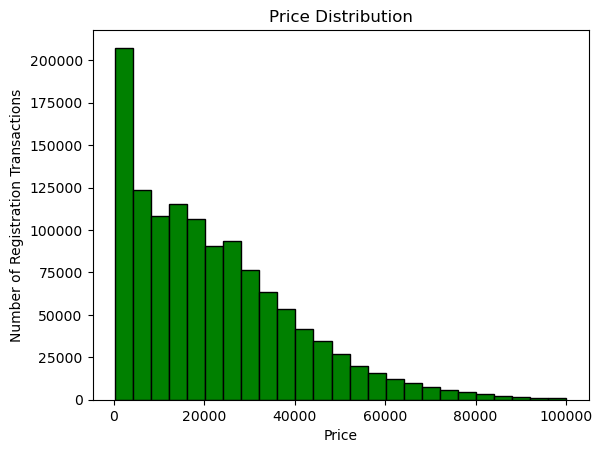

In [7]:
#plot the distribution of the price values

temp = tn_auto_reg_f.loc[tn_auto_reg_f["price"]<100000]
plt.hist(temp['price'], color='green', ec='black', bins=25) #, range=[0,60])
plt.title("Price Distribution")
plt.xlabel("Price")
plt.ylabel("Number of Registration Transactions")

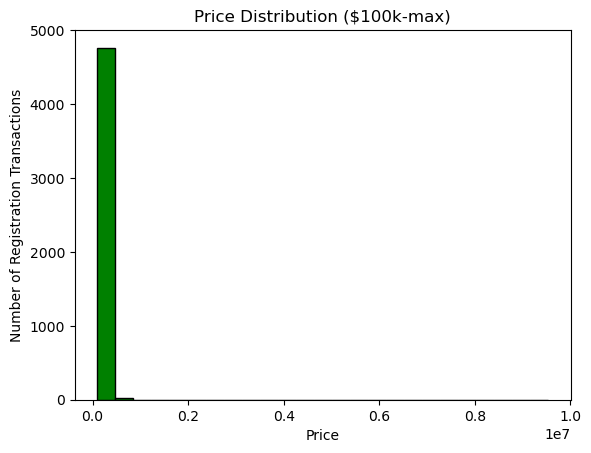

Note the drastically different range when compared to the 0-100K distribution above.  Only 3.5k max num transactions.


In [8]:
#plot the distribution of the price values
temp = tn_auto_reg_f.loc[tn_auto_reg_f["price"]>=100000]
plt.hist(temp['price'], color='green', ec='black', bins=25) #, range=[0,60])
plt.title("Price Distribution ($100k-max)")
plt.xlabel("Price")
plt.ylabel("Number of Registration Transactions")
plt.show()
print("Note the drastically different range when compared to the 0-100K distribution above.  Only 3.5k max num transactions.")

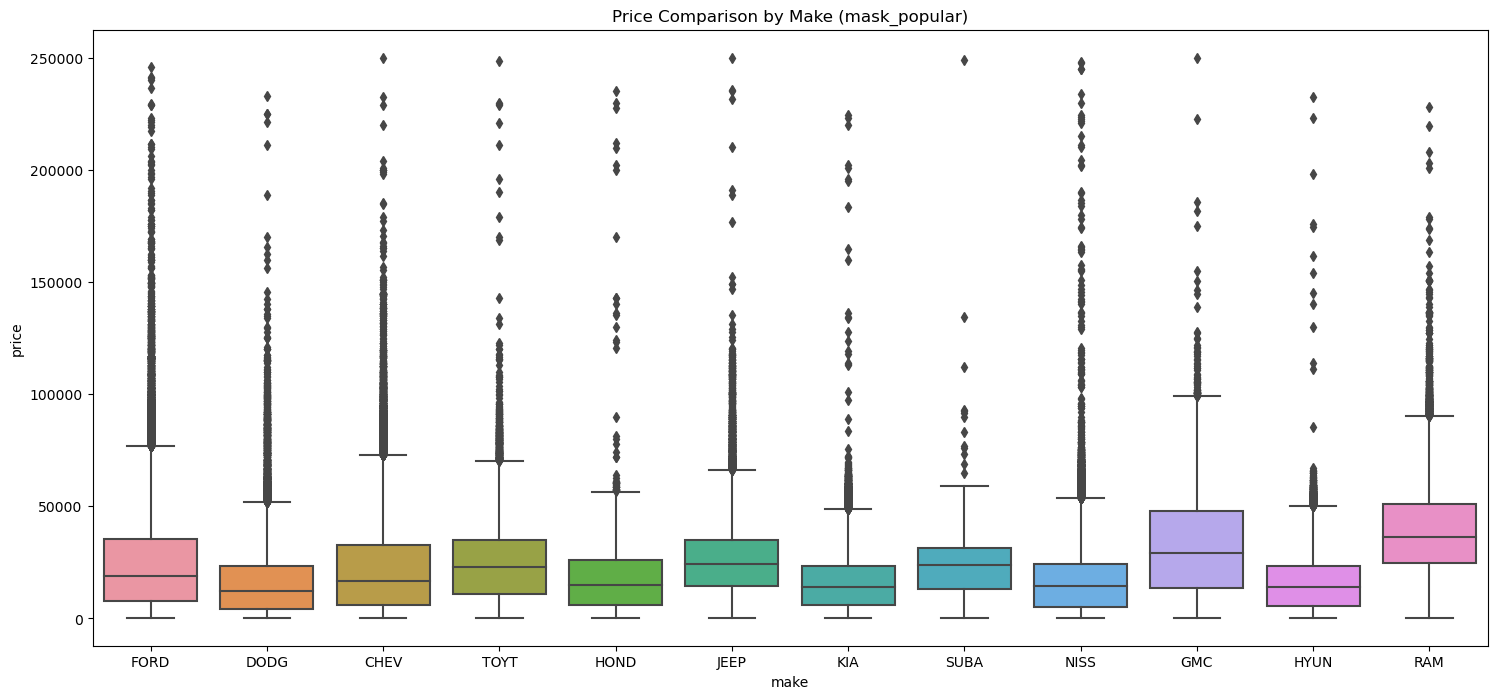

In [9]:
plt.figure(figsize=(18,8))
sns.boxplot(x="make", y="price", data=tn_auto_reg_f[mask_popular])
plt.title("Price Comparison by Make (mask_popular)")
plt.show()

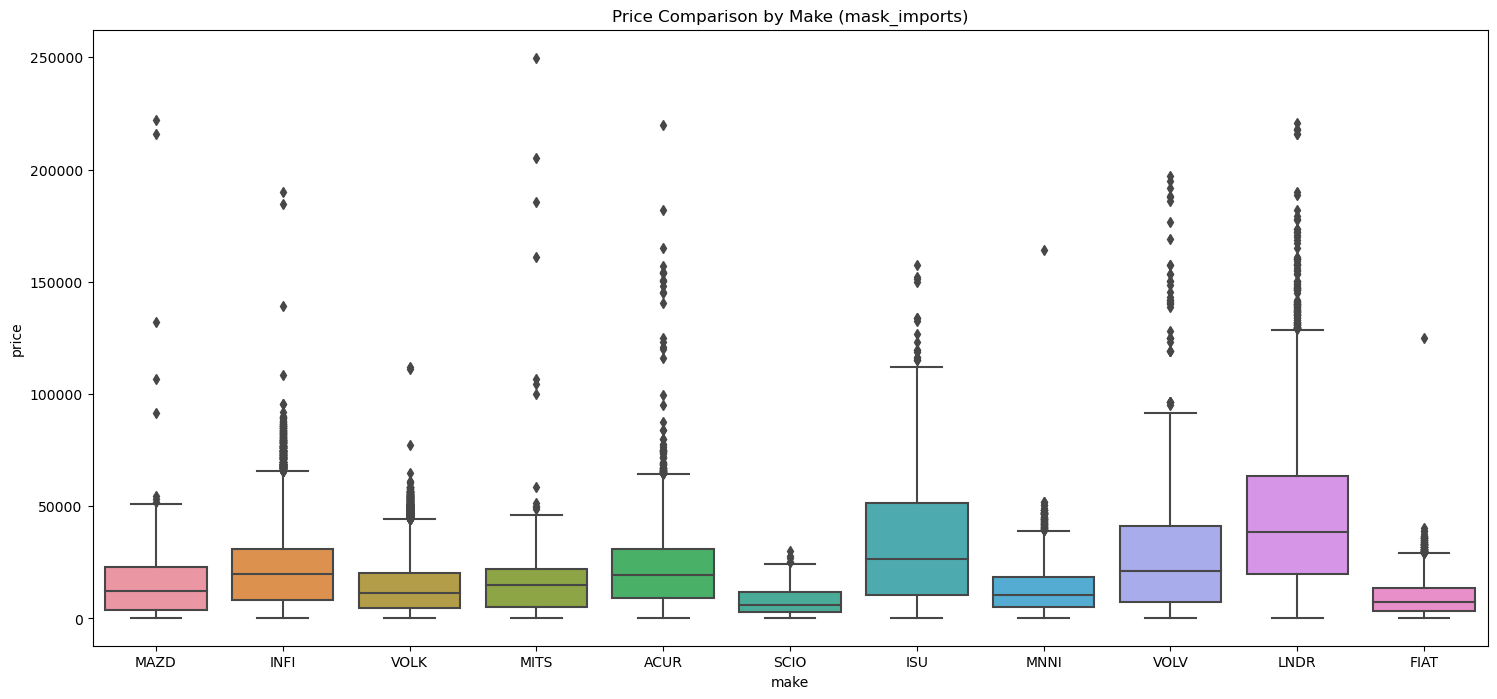

In [10]:
plt.figure(figsize=(18,8))
sns.boxplot(x="make", y="price", data=tn_auto_reg_f[mask_imports])
plt.title("Price Comparison by Make (mask_imports)")
plt.show()

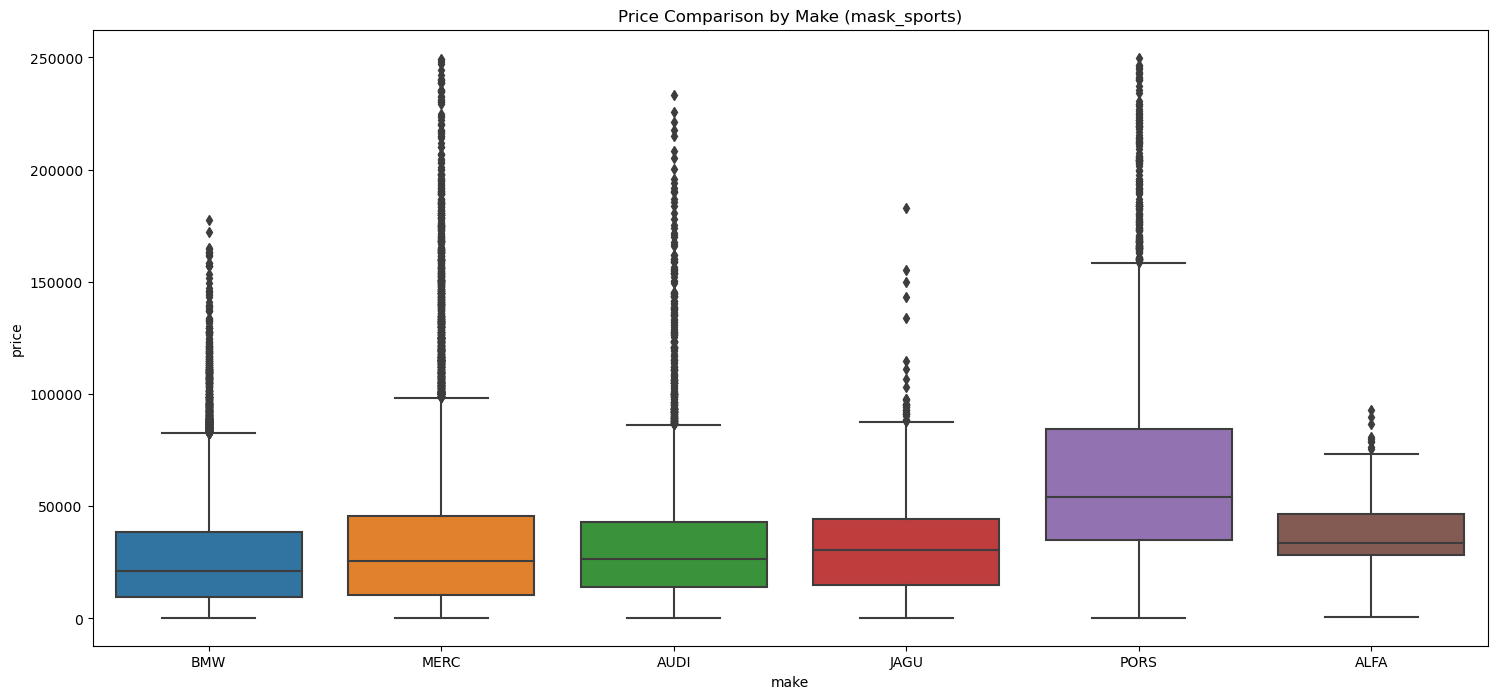

In [11]:
plt.figure(figsize=(18,8))
sns.boxplot(x="make", y="price", data=tn_auto_reg_f[mask_sports])
plt.title("Price Comparison by Make (mask_sports)")
plt.show()

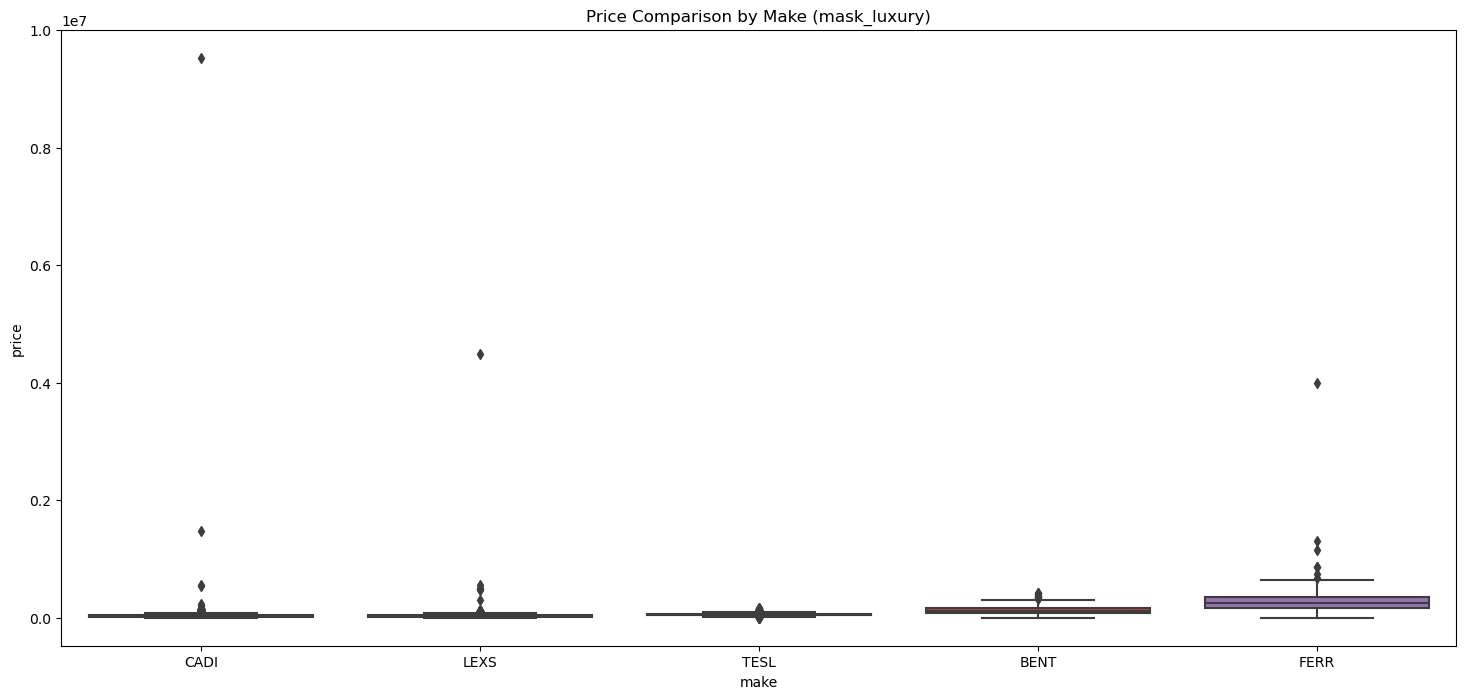

In [12]:
plt.figure(figsize=(18,8))
sns.boxplot(x="make", y="price", data=tn_auto_reg_f[mask_luxury])
plt.title("Price Comparison by Make (mask_luxury)")
plt.show()

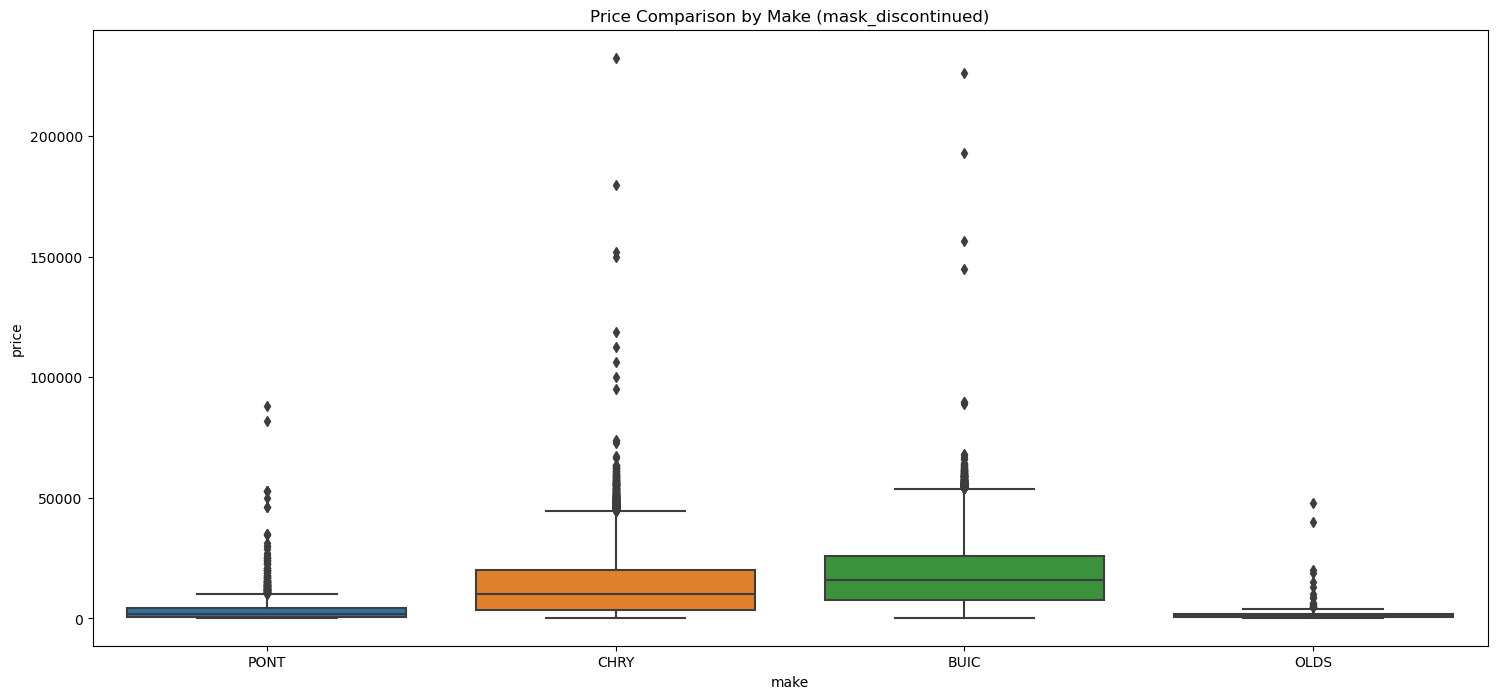

In [13]:
plt.figure(figsize=(18,8))
sns.boxplot(x="make", y="price", data=tn_auto_reg_f[mask_discontinued])
plt.title("Price Comparison by Make (mask_discontinued)")
plt.show()

Number of results: 10920


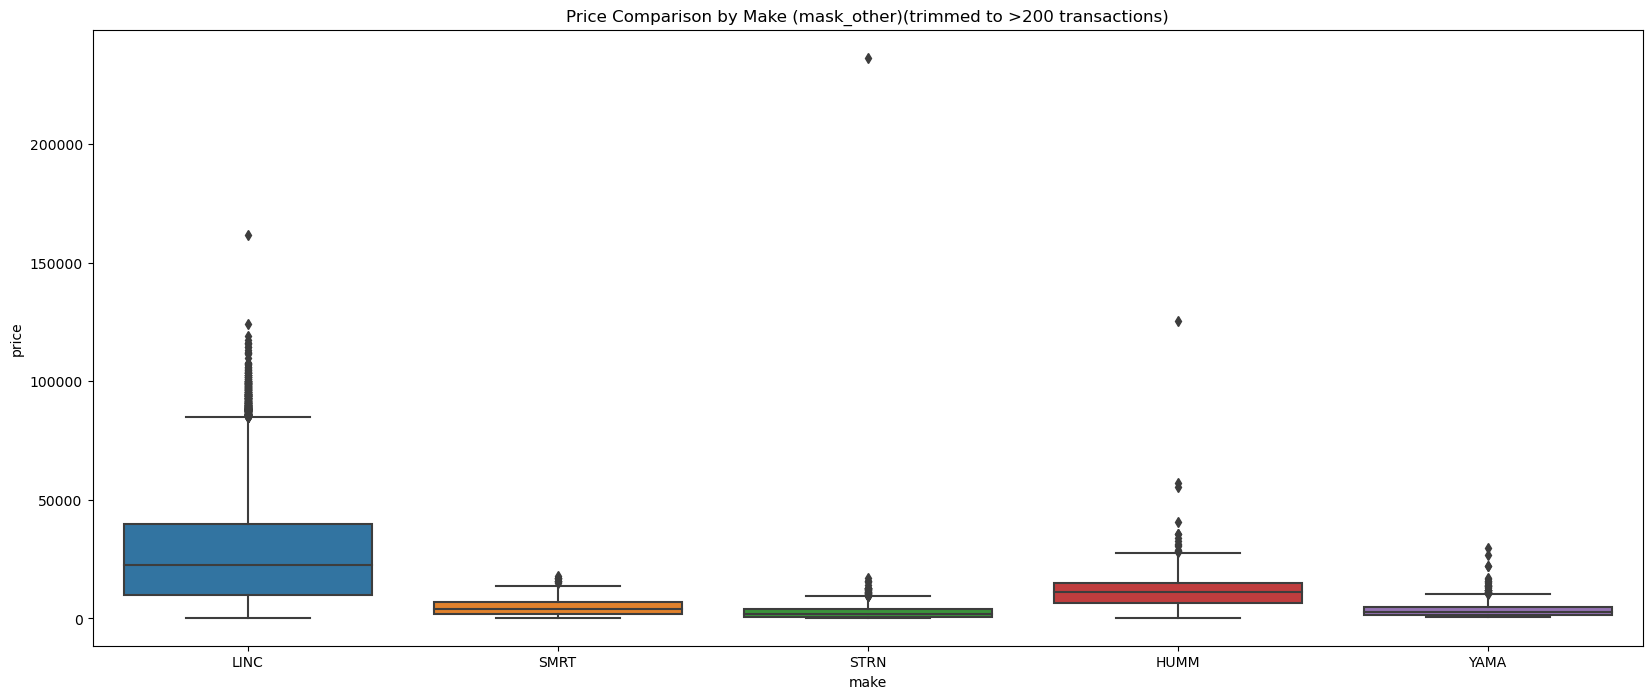

In [14]:
#trimming this down to significant data points (more than 200 transactions)
make_counts = tn_auto_reg_f['make'].value_counts()
mask_make_counts = tn_auto_reg_f['make'].isin(make_counts[make_counts > 200].index)

#boxplot like all the other masks above
plt.figure(figsize=(20,8))
sns.boxplot(x="make", y="price", data=tn_auto_reg_f[mask_other & mask_make_counts])
print("Number of results: " + str(len(tn_auto_reg_f[mask_other & mask_make_counts])))
plt.title("Price Comparison by Make (mask_other)(trimmed to >200 transactions)")
plt.show()

In [15]:
print("Showing the other mask, noting that less than 200 transactions were excluded from the above boxplot")
tn_auto_reg_f[mask_other]['make'].value_counts()

Showing the other mask, noting that less than 200 transactions were excluded from the above boxplot


LINC    8457
STRN    1010
SMRT     566
YAMA     481
HUMM     406
Name: make, dtype: int64

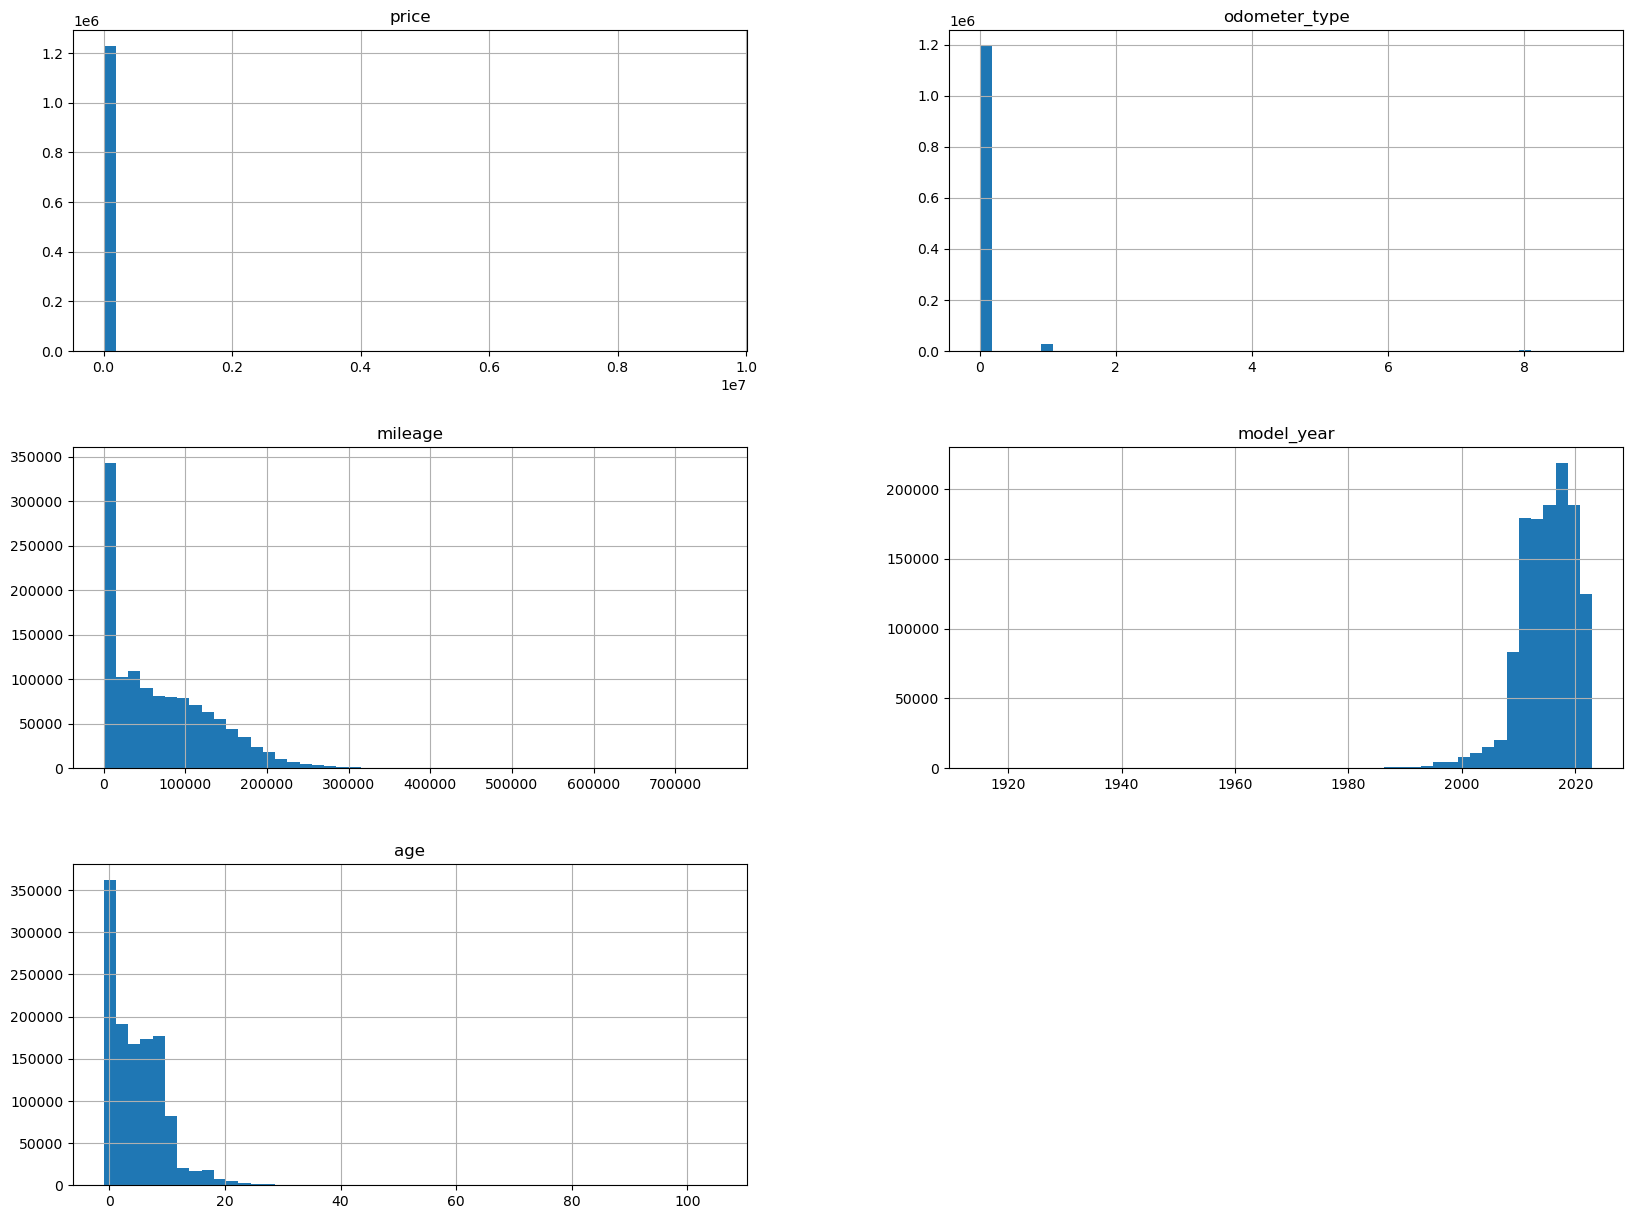

Price, mileage, and age are confirmed by corr analysis to be strong indicators.
Striving for a normal distribution will take some work


In [16]:
tn_auto_reg_f[["price","odometer_type","mileage","model_year","age"]].hist(bins=50, figsize=(20,15))
plt.show()
print("Price, mileage, and age are confirmed by corr analysis to be strong indicators.")
print("Striving for a normal distribution will take some work")

In [17]:
tn_auto_reg_f['price_log'] = np.log1p(tn_auto_reg_f['price'])
tn_auto_reg_f['mileage_log'] = np.log1p(tn_auto_reg_f['mileage'])


Log(age) didn't compute and model year didn't look any different.  Left them alone

Showing transformations on right side that will be prefered in ML algorithm


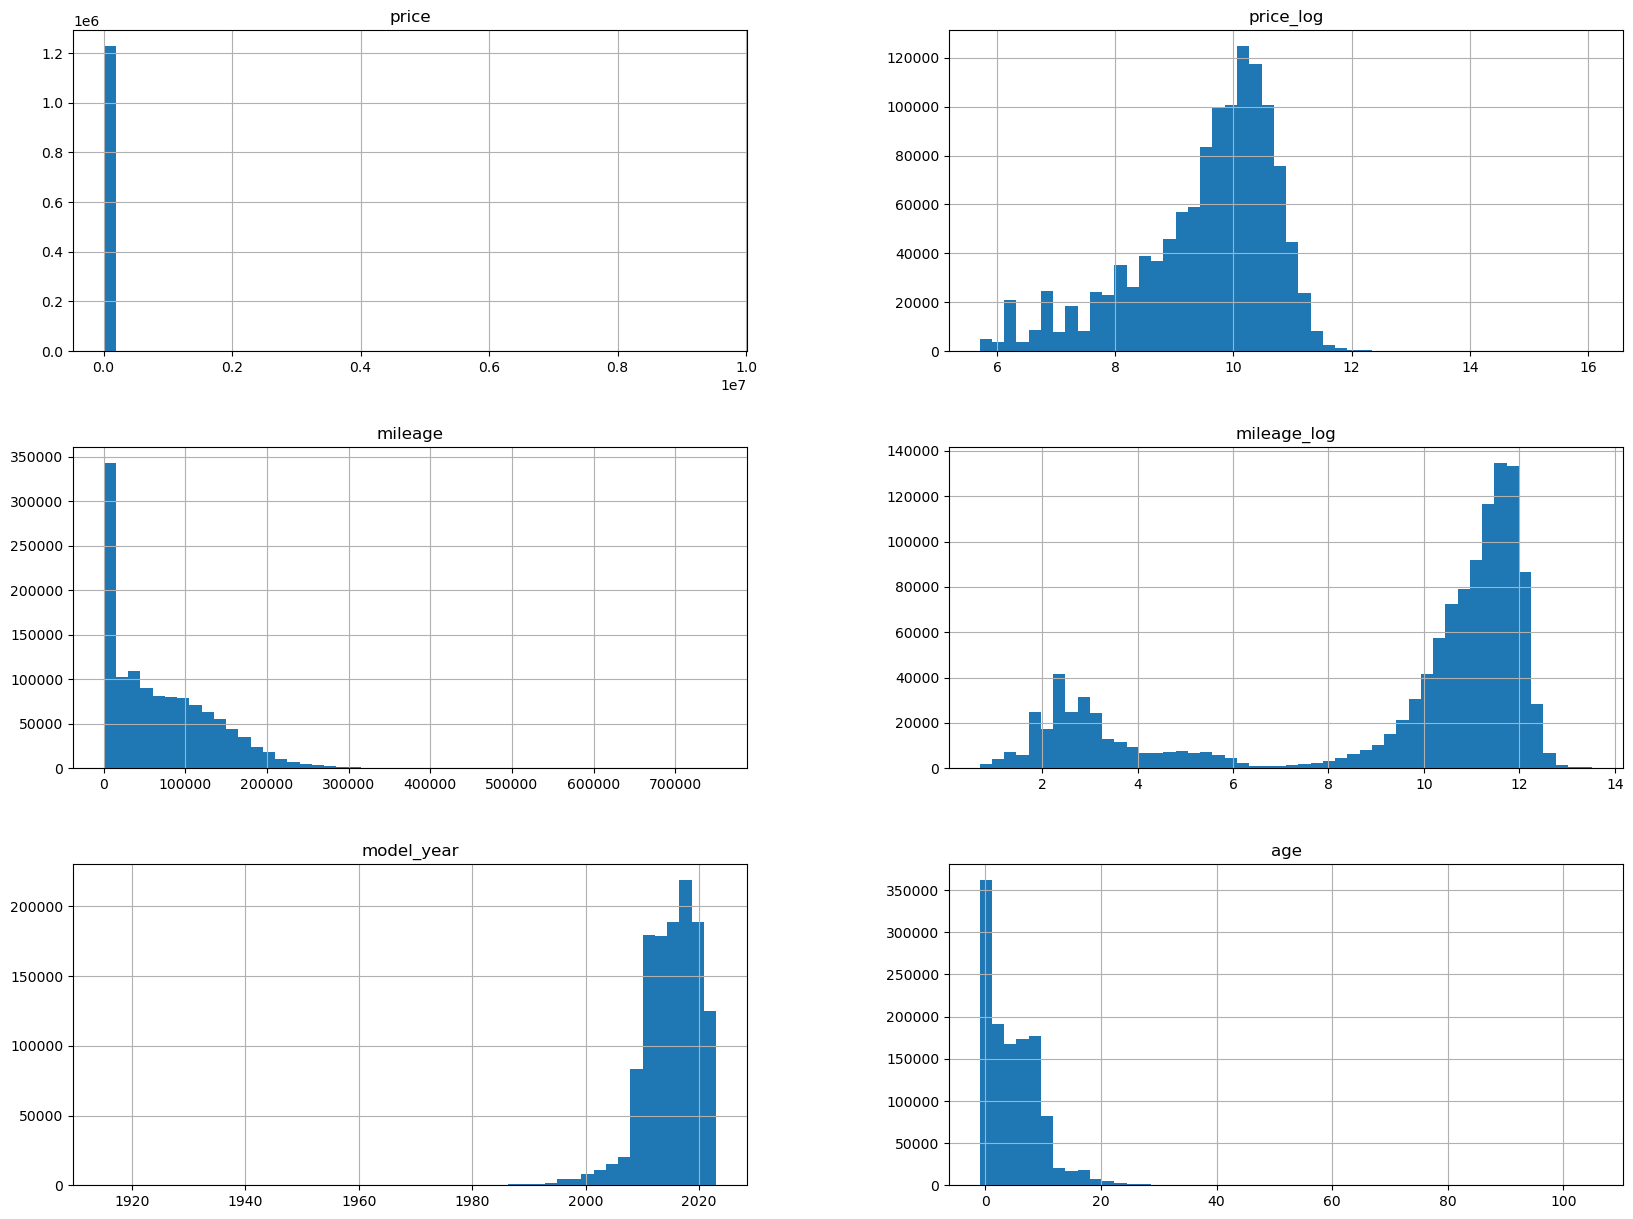

In [18]:
print("Showing transformations on right side that will be prefered in ML algorithm")
tn_auto_reg_f[["price","price_log","mileage","mileage_log","model_year","age"]].hist(bins=50, figsize=(20,15))
plt.show()

In [19]:
# determine an average price for each make/model for both new and used vehicles
avg_price = tn_auto_reg_f.groupby(['make', 'model', 'new_used_N'])['price'].mean().reset_index()
avg_price = avg_price.pivot_table(index=['make', 'model'], columns='new_used_N', values='price', aggfunc='first').reset_index()
avg_price.columns.name = None
avg_price = avg_price[['make', 'model', 1, 0]]

# filter to only rows with non-null values in both 'new' and 'used' columns
avg_price_filtered = avg_price[avg_price[[1, 0]].notnull().all(axis=1)]

# change column names 
avg_price_filtered = avg_price_filtered.rename(columns={'1': 'new_avg', '0': 'used_avg'})

print("Average prices shown below: 1 is New, 0 is Used")
print(avg_price_filtered.sample(20).round(0))

print("Seeing some models go up on average.")

Average prices shown below: 1 is New, 0 is Used
      make model         1         0
7333  VOLV   XC9   62642.0   29204.0
6453  SUBA   GR8   32561.0   42527.0
2570  FORD   Fus   27850.0   13955.0
4671  LEXS   RX4   44175.0   17909.0
4077  JAGU   IPC   76350.0   55737.0
3081   GMC   CNY   45948.0   28120.0
1509  CHEV   SUB   68182.0   29098.0
2409  FORD   F10   92869.0    4792.0
7009  VOLK   1C2   40216.0   23709.0
3412  HOND   CIV   25220.0   11479.0
6240   RAM   DS6   44679.0   35576.0
4558  LEXS   350   49905.0   22745.0
6754  TOYT   GRS   56554.0   57377.0
3777  HYUN   Pal   47086.0   42535.0
2052  FERR   ZFF  350523.0  289264.0
743   CADI   ATS   39168.0   16688.0
5162  MERC   E45   91428.0   57655.0
5156  MERC   E30   55368.0   35860.0
6422  SUBA   4S3   29174.0    5516.0
4275  JEEP   REG   20683.0   19235.0
Seeing some models go up on average.


C:\Users\bobbs\AppData\Local\Temp\ipykernel_19596\3464386721.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['New', 'Used'])


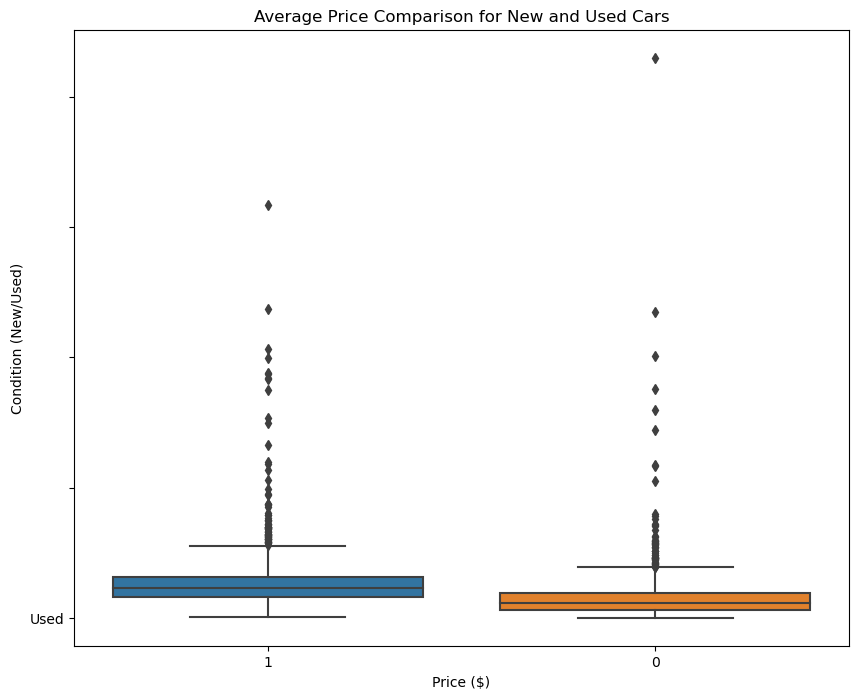

In [20]:
# Create figure and axis objects
fig, ax = plt.subplots(figsize=(10,8))

# Plot boxplots for new and used cars side by side
sns.boxplot(data=avg_price_filtered[[1, 0]],  ax=ax)

# Set title and axis labels
ax.set_title("Average Price Comparison for New and Used Cars")
ax.set_xlabel("Price ($)")
ax.set_ylabel("Condition (New/Used)")
ax.set_yticklabels(['New', 'Used'])

# Show plot
plt.show()

             price_log  mileage_log   age  new_used_N  type_TRUCK
price_log         1.00        -0.55 -0.70        0.42        0.18
mileage_log      -0.55         1.00  0.63       -0.86       -0.04
age              -0.70         0.63  1.00       -0.49       -0.01
new_used_N        0.42        -0.86 -0.49        1.00        0.05
type_TRUCK        0.18        -0.04 -0.01        0.05        1.00


<AxesSubplot: title={'center': 'Population - New/Used Cars/Trucks'}>

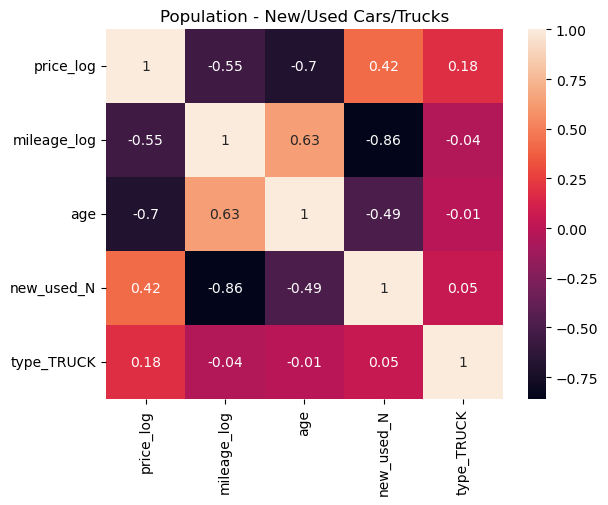

In [21]:
#overall corr analysis
tn_auto_reg_f_hm = tn_auto_reg_f[["price_log","mileage_log","age",'new_used_N',"type_TRUCK"]].corr().round(2)
print(tn_auto_reg_f_hm)
plt.title("Population - New/Used Cars/Trucks")
sns.heatmap(tn_auto_reg_f_hm, annot=True)

Adding new features and testing around.  Should have done this the first time around :/


<AxesSubplot: title={'center': 'Population - New/Used Cars/Trucks'}>

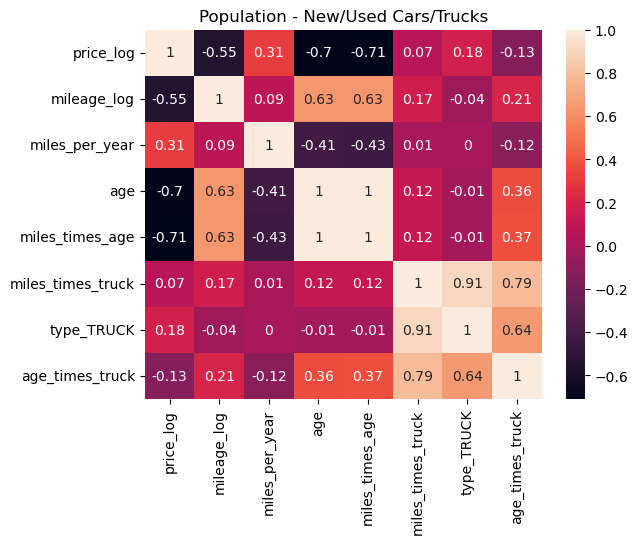

In [22]:
print("Adding new features and testing around.  Should have done this the first time around :/")

tn_auto_reg_f["miles_per_year"] = tn_auto_reg_f["mileage_log"] / tn_auto_reg_f["age"]
tn_auto_reg_f["miles_times_truck"] = tn_auto_reg_f["mileage_log"] * tn_auto_reg_f["type_TRUCK"]
tn_auto_reg_f["miles_times_age"] = tn_auto_reg_f["mileage_log"] * tn_auto_reg_f["age"]
tn_auto_reg_f["age_times_truck"] = tn_auto_reg_f["age"] * tn_auto_reg_f["type_TRUCK"]

tn_auto_reg_f_hm2 = tn_auto_reg_f[["price_log", "mileage_log","miles_per_year","age", 'miles_times_age',
                                  "miles_times_truck","type_TRUCK","age_times_truck"]].corr().round(2)
#print(tn_auto_reg_f_hm2)
plt.title("Population - New/Used Cars/Trucks")
sns.heatmap(tn_auto_reg_f_hm2, annot=True)


Liking miles_per_year as an indicator of wear and tear.  Miles_times_truck comes in at .007 which pales in comparison of truck at .18 and mileage_log at -.55.

Interesting that miles_times_age has a -.71 which beats mileage_log at -.55 and age at -.07.  Might use this feature and delete the other two from the new transformer. 

In [23]:
#trim down models because there is trash in it
print(tn_auto_reg_f['model'].value_counts().tail(10) )

model_counts = tn_auto_reg_f['model'].value_counts()
selected_models = model_counts[model_counts > 200].index
tn_auto_reg_f = tn_auto_reg_f[tn_auto_reg_f['model'].isin(selected_models)]

print("Finished trimming (models with fewer than 200 transactions were deleted.)\nCounts of models and stats on number of records")
print(tn_auto_reg_f['model'].value_counts().describe() )

4HP    1
R1Z    1
SJN    1
E4H    1
R70    1
QTO    1
BV4    1
O6R    1
F5S    1
F40    1
Name: model, dtype: int64
Finished trimming (models with fewer than 200 transactions were deleted.)
Counts of models and stats on number of records
count      505.000000
mean      2287.871287
std       4646.336791
min        201.000000
25%        341.000000
50%        646.000000
75%       1825.000000
max      47718.000000
Name: model, dtype: float64


In [24]:
from sklearn.preprocessing import OrdinalEncoder

##Make
tn_auto_reg_f_cat_make = tn_auto_reg_f[['make']]

ordinal_encodert_make = OrdinalEncoder()
tn_auto_reg_f_cat_make_encoded = ordinal_encodert_make.fit_transform(tn_auto_reg_f_cat_make)
np.unique(tn_auto_reg_f_cat_make_encoded)

print(ordinal_encodert_make.categories_)

##Model
tn_auto_reg_f_cat_model = tn_auto_reg_f[['model']]

ordinal_encoder_model = OrdinalEncoder()
tn_auto_reg_f_cat_model_encoded = ordinal_encoder_model.fit_transform(tn_auto_reg_f_cat_model)
np.unique(tn_auto_reg_f_cat_model_encoded)

print(ordinal_encoder_model.categories_)

[array(['ACUR', 'ALFA', 'AUDI', 'BENT', 'BMW', 'BUIC', 'CADI', 'CHEV',
       'CHRY', 'DODG', 'FERR', 'FIAT', 'FORD', 'GMC', 'HOND', 'HUMM',
       'HYUN', 'INFI', 'ISU', 'JAGU', 'JEEP', 'KIA', 'LEXS', 'LINC',
       'LNDR', 'MAZD', 'MERC', 'MITS', 'MNNI', 'NISS', 'OLDS', 'PONT',
       'PORS', 'RAM', 'SCIO', 'SMRT', 'STRN', 'SUBA', 'TESL', 'TOYT',
       'VOLK', 'VOLV', 'YAMA'], dtype=object)]
[array(['150', '15V', '1C6', '1FD', '1FT', '1NC', '1NK', '1SL', '1ST',
       '200', '228', '250', '25V', '28I', '2CH', '2K2', '2KH', '2LM',
       '2LX', '2NK', '2SC', '2SK', '2ST', '2TR', '300', '320', '328',
       '330', '335', '350', '370', '3C7', '3SK', '428', '450', '4RN',
       '4RU', '500', '528', '535', '54D', '550', '5XY', '650', '750',
       '911', 'A2S', 'A3', 'A5', 'A5S', 'A7', 'AA', 'AA4', 'AA6', 'AA8',
       'ACA', 'ACC', 'ALT', 'ARM', 'ASC', 'ASE', 'ASL', 'AST', 'ATL',
       'ATS', 'AVA', 'AVN', 'AVO', 'AXL', 'AXT', 'BLT', 'BLZ', 'BOX',
       'BRO', 'BRZ', 'BUG', 'BX5', 'C1

In [25]:
# Sort by VIN
sorted = tn_auto_reg_f.sort_values(by=['vin','title_issue_date'])

# Count the number of records per VIN 
vin_counts = sorted['vin'].value_counts()

# Exclude any cars with less than 2 records
multiple_vins = vin_counts[vin_counts > 2].index

sorted = sorted[sorted['vin'].isin(multiple_vins)] #refactor here? 
print("Number of VINs with more than 2 records:", len(multiple_vins))

Number of VINs with more than 2 records: 9438


Most vehicles decrease in value after converting to new, but a few increase in value. Believe it makes sense that a dealership may value a trade-in at a lower price than when it is resold on their lot. 

Below begins the 3rd stage gate 


In [26]:
nowish = time.time() - startTime
last = time.time() - mostRecentTime
print('Analysis completed (total time): ' + str(round(nowish,0)) )
print("This section took: " + str(round(last,0) ) )
print("(in seconds)")

mostRecentTime = time.time()

Analysis completed (total time): 40.0
This section took: 32.0
(in seconds)


Below is the code for the final stagegate of this term project. 

In [27]:
print("Dropping all non-feature columns\n")
dropped = tn_auto_reg_f.drop("vin", axis=1)
dropped = dropped.drop("odometer_type", axis=1)
dropped = dropped.drop("county", axis=1)
dropped = dropped.drop("zip", axis=1)
dropped = dropped.drop("model_year", axis=1)
#dropped = dropped.drop("make", axis=1)  #One hot encoded!
dropped = dropped.drop("model", axis=1)  
dropped = dropped.drop("vehicle_type", axis=1)
dropped = dropped.drop("new_used", axis=1)
dropped = dropped.drop("title_issue_date", axis=1)
dropped = dropped.drop("purchase_date", axis=1)
dropped = dropped.drop("mileage", axis=1)
dropped = dropped.drop("price", axis=1)

dropped = dropped.drop("make_cat_popular", axis=1)
dropped = dropped.drop("make_cat_imports", axis=1)
dropped = dropped.drop("make_cat_sports", axis=1)
dropped = dropped.drop("make_cat_discontinued", axis=1)
dropped = dropped.drop("make_cat_other", axis=1)
dropped = dropped.drop("type_AUTO", axis=1)
dropped = dropped.drop("new_used_U", axis=1)

dropped = dropped.drop("miles_times_truck", axis=1)
dropped = dropped.drop("age_times_truck", axis=1)

dropped = dropped.drop("miles_per_year", axis=1) #keeping this as a measure of excessive wear and tear
dropped = dropped.drop("miles_times_age", axis=1) #decided to delete this in the end.  
#already have miles and age included as strong indicators

#Hot encode for: "FORD-F150"
#Check for intereaction between mileage and type of vehicle
# age * mileage 
# ageXmileage * vehicle type (or make or model) 

dropped.info()

Dropping all non-feature columns

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1155375 entries, 0 to 1231110
Data columns (total 7 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   make             1155375 non-null  object 
 1   age              1155375 non-null  int64  
 2   make_cat_luxury  1155375 non-null  int64  
 3   type_TRUCK       1155375 non-null  int64  
 4   new_used_N       1155375 non-null  int64  
 5   price_log        1155375 non-null  float64
 6   mileage_log      1155375 non-null  float64
dtypes: float64(2), int64(4), object(1)
memory usage: 70.5+ MB


<AxesSubplot: title={'center': 'Population - New/Used Cars/Trucks'}>

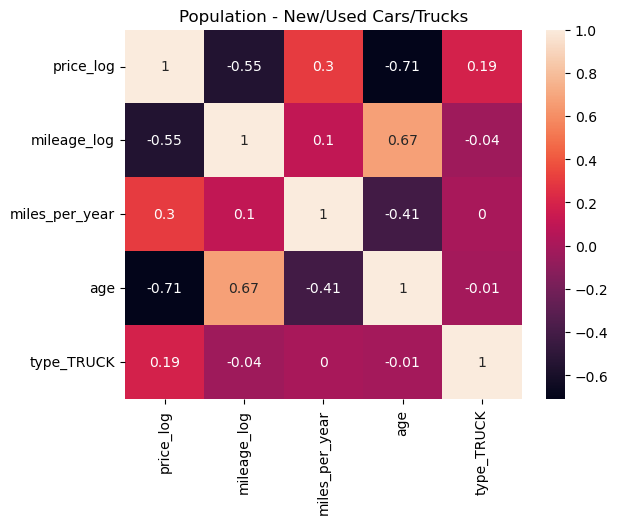

In [28]:

tn_auto_reg_f_hm2 = tn_auto_reg_f[["price_log", "mileage_log","miles_per_year","age", "type_TRUCK"]].corr().round(2)
#print(tn_auto_reg_f_hm2)
plt.title("Population - New/Used Cars/Trucks")
sns.heatmap(tn_auto_reg_f_hm2, annot=True)


In [29]:
from sklearn.preprocessing import OrdinalEncoder

tn_auto_reg_f_cat_make = tn_auto_reg_f[['make']]

ordinal_encoder = OrdinalEncoder()
tn_auto_reg_f_cat_make_encoded = ordinal_encoder.fit_transform(tn_auto_reg_f_cat_make)
np.unique(tn_auto_reg_f_cat_make_encoded)

ordinal_encoder.categories_

[array(['ACUR', 'ALFA', 'AUDI', 'BENT', 'BMW', 'BUIC', 'CADI', 'CHEV',
        'CHRY', 'DODG', 'FERR', 'FIAT', 'FORD', 'GMC', 'HOND', 'HUMM',
        'HYUN', 'INFI', 'ISU', 'JAGU', 'JEEP', 'KIA', 'LEXS', 'LINC',
        'LNDR', 'MAZD', 'MERC', 'MITS', 'MNNI', 'NISS', 'OLDS', 'PONT',
        'PORS', 'RAM', 'SCIO', 'SMRT', 'STRN', 'SUBA', 'TESL', 'TOYT',
        'VOLK', 'VOLV', 'YAMA'], dtype=object)]

In [30]:
def price_cat_proportions(data):
    #print ("Data_price_log.value_counts() = \n" + str(data["price_log"].value_counts() ) +" and len = " + str( (len(data) + 1e-10 )))
    return data["price_log"].value_counts() / (len(data) + 1e-10)

dropped_shuffled = dropped.sample(frac=1)

train_set, test_set = train_test_split(dropped_shuffled, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": price_cat_proportions(tn_auto_reg_f),
    #"Stratified": price_cat_proportions(strat_test_set_disc),
    "Random": price_cat_proportions(test_set),
}).sort_index()#.fillna(0) #<- Debugging Flag - Not sure about .fillna(0) here.  Should figure out why NaNs popped up. 
compare_props["Rand. %error"] = ( 100 * compare_props["Random"] ) / (compare_props["Overall"] - 100 )    #<- are these supposed
#compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100 #<- to be different? Was 1

#Look for divide by zero errors here => NaN 

## the stratified better reflects the original distribution?
compare_props.sample(15).round(-1)

,Overall,Random,Rand. %error
10.184695,0.0,0.0,-0.0
11.286840,0.0,NaN,NaN
10.148566,0.0,NaN,NaN
10.511512,0.0,0.0,-0.0
10.179693,0.0,0.0,-0.0
11.081155,0.0,NaN,NaN
9.640771,0.0,NaN,NaN
7.883446,0.0,NaN,NaN
8.602269,0.0,NaN,NaN
7.248838,0.0,0.0,-0.0


In [31]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler

In [32]:
from sklearn.preprocessing import OrdinalEncoder

cat_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OrdinalEncoder()),
])

In [33]:
# get the right column indices: safer than hard-coding indices 3, 4, 5, 6
#rooms_ix, bedrooms_ix, population_ix, household_ix = [
#    list(housing.columns).index(col)
#    for col in ("total_rooms", "total_bedrooms", "population", "households")]
#bedrooms_ix

#def add_extra_features(X, add_bedrooms_per_room=True):
#    rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
#    population_per_household = X[:, population_ix] / X[:, household_ix]
#    if add_bedrooms_per_room:
#        bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
#        return np.c_[X, rooms_per_household, population_per_household,
#                     bedrooms_per_room]
#    else:
#        return np.c_[X, rooms_per_household, population_per_household]

In [34]:
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        #('attribs_adder', FunctionTransformer(add_extra_features, validate=False)),
        ('std_scaler', StandardScaler()),
    ])

In [35]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder_make = OneHotEncoder(sparse=False)
tn_auto_reg_f_cat_1hot_make = cat_encoder_make.fit_transform(tn_auto_reg_f_cat_make)
print(tn_auto_reg_f_cat_1hot_make)

#cat_encoder_model = OneHotEncoder(sparse=False)
#tn_auto_reg_f_cat_1hot_model = cat_encoder_model.fit_transform(tn_auto_reg_f_cat_model)
#print(tn_auto_reg_f_cat_1hot_model)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [36]:
#Copy the target into the labels set
registrations_labels = train_set['price_log'].copy()

#Copy the dropped data into the registrations df 
registrations = train_set.drop('price_log',axis=1).copy()

print(registrations.info() )
print("\n")
print(registrations_labels.info() )

<class 'pandas.core.frame.DataFrame'>
Int64Index: 924300 entries, 794743 to 126452
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   make             924300 non-null  object 
 1   age              924300 non-null  int64  
 2   make_cat_luxury  924300 non-null  int64  
 3   type_TRUCK       924300 non-null  int64  
 4   new_used_N       924300 non-null  int64  
 5   mileage_log      924300 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 49.4+ MB
None


<class 'pandas.core.series.Series'>
Int64Index: 924300 entries, 794743 to 126452
Series name: price_log
Non-Null Count   Dtype  
--------------   -----  
924300 non-null  float64
dtypes: float64(1)
memory usage: 14.1 MB
None


In [37]:
registrations.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 924300 entries, 794743 to 126452
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   make             924300 non-null  object 
 1   age              924300 non-null  int64  
 2   make_cat_luxury  924300 non-null  int64  
 3   type_TRUCK       924300 non-null  int64  
 4   new_used_N       924300 non-null  int64  
 5   mileage_log      924300 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 49.4+ MB


In [38]:
from sklearn.compose import ColumnTransformer

num_attribs = ["mileage_log","age"] 
cat_attribs = ["new_used_N","make_cat_luxury","type_TRUCK"]
hot_attribs = ["make" ] #, "model"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", cat_pipeline, cat_attribs),
        ("hot", OneHotEncoder(), hot_attribs),
    ])

#registrations = registrations.drop("make", axis=1)  
#registrations = registrations.drop("model", axis=1)  

registrations_prepared = full_pipeline.fit_transform(registrations)

C:\Users\bobbs\anaconda3\lib\site-packages\sklearn\impute\_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


In [39]:
registrations_prepared

<924300x47 sparse matrix of type '<class 'numpy.float64'>'
	with 3161651 stored elements in Compressed Sparse Row format>

In [40]:
registrations_prepared.shape

(924300, 47)

In [41]:
nowish = time.time() - startTime
last = time.time() - mostRecentTime
print('Pipline created (total time): ' + str(round(nowish,0)) )
print("This section took: " + str(round(last,0) ) )
print("(in seconds)")

mostRecentTime = time.time()

Pipline created (total time): 52.0
This section took: 12.0
(in seconds)


In [42]:
#import statsmodels.api as sm
#X_const = sm.add_constant(registrations_prepared)
#OLS_model = sm.OLS(registrations_labels,X_const) 
#result = OLS_model.fit()
#result.summary()

In [43]:
from sklearn.linear_model import LinearRegression

#Maybe flip flopped _prepared and _labels here 

lin_reg = LinearRegression()
lin_reg.fit(registrations_prepared, registrations_labels)
 

LinearRegression()

In [44]:
print(registrations_prepared.shape)
print(registrations_labels.shape)

(924300, 47)
(924300,)


In [45]:
# let's try the full preprocessing pipeline on a few training instances
#some_data = registrations_prepared[:5]
#some_labels = registrations_labels[:5]

#cols = num_attribs + cat_attribs + hot_attribs

#some_data_df = pd.DataFrame(some_data, columns=cols)

#some_data_prepared = full_pipeline.transform(some_data_df)



In [46]:
#Compare prediction against the actual values
#print("Predictions:", list(np.round(lin_reg.predict(some_data_prepared),1)))
#print("Labels     :", list(some_labels))

In [47]:
nowish = time.time() - startTime
last = time.time() - mostRecentTime
print('First Predictions Completed (total time): ' + str(round(nowish,0)) )
print("This section took: " + str(round(last,0) ) )
print("(in seconds)")

mostRecentTime = time.time()

First Predictions Completed (total time): 57.0
This section took: 5.0
(in seconds)


In [48]:
from sklearn.metrics import mean_squared_error

vehicle_price_predictions = lin_reg.predict(registrations_prepared)
lin_mse = mean_squared_error(registrations_labels, vehicle_price_predictions)
lin_rmse = np.sqrt(lin_mse)

print("Root Mean Squared Error:", round(lin_rmse,-2))


Root Mean Squared Error: 0.0


In [49]:
from sklearn.metrics import mean_absolute_error

registrations_predictions = lin_reg.predict(registrations_prepared)
lin_mae = mean_absolute_error(registrations_labels, registrations_predictions)
print("Mean Absolute Error:", round(lin_mae,1))

Mean Absolute Error: 0.5


In [50]:
# from sklearn.metrics import mean_absolute_percentage_error# mean_absolute_error

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print("Absolute Percentage Error:")
round(mean_absolute_percentage_error(registrations_labels, registrations_predictions),1)

#This is the one to use to show how wide the error band is in real world prices

Absolute Percentage Error:


6.1

In [51]:
nowish = time.time() - startTime
last = time.time() - mostRecentTime
print('Errors computed (total time): ' + str(round(nowish,0)) )
print("This section took: " + str(round(last,0) ) )
print("(in seconds)")

mostRecentTime = time.time()

Errors computed (total time): 57.0
This section took: 0.0
(in seconds)


In [52]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(registrations_prepared, registrations_labels)

DecisionTreeRegressor(random_state=42)

In [53]:
registrations_predictions = tree_reg.predict(registrations_prepared)
tree_mse = mean_squared_error(registrations_labels, registrations_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.2515594500696768

In [54]:
mean_absolute_percentage_error(registrations_labels, registrations_predictions)

1.0664550808892639

In [55]:
nowish = time.time() - startTime
last = time.time() - mostRecentTime
print('Tree fit completed (total time): ' + str(round(nowish,0)) )
print("This section took: " + str(round(last,0) ) )
print("(in seconds)")

mostRecentTime = time.time()

Tree fit completed (total time): 936.0
This section took: 879.0
(in seconds)


#Slow below here#

In [ ]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=10, random_state=42)
forest_reg.fit(registrations_prepared, registrations_labels)

In [ ]:
registrations_predictions = forest_reg.predict(registrations_prepared)
forest_mse = mean_squared_error(registrations_labels, registrations_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

In [ ]:
nowish = time.time() - startTime
last = time.time() - mostRecentTime
print('Forest fit completed (total time): ' + str(round(nowish,0)) )
print("This section took: " + str(round(last,0) ) )
print("(in seconds)")

mostRecentTime = time.time()

In [ ]:
#Copy the target into the labels set
test_Y = test_set['price_log'].copy()

#Copy the dropped data into the registrations df 
test_X = test_set.drop('price_log',axis=1).copy()

In [ ]:
#choosing tree_reg as the best fit with an rmse of .36 since lower than 
#forest_reg at .46, and assuming linear_reg is errored at 0
tree_predictions = tree_reg.predict(test_X)

In [ ]:
from sklearn.metrics import r2_score
r2_score(test_Y, tree_predictions)

In [ ]:
#choosing tree_reg as the best fit with an rmse of .36 since lower than 
#forest_reg at .46, and assuming linear_reg is errored at 0
forest_predictions = forest_reg.predict(test_X)

In [ ]:
r2_score(test_Y, forest_predictions)

In [ ]:
#choosing tree_reg as the best fit with an rmse of .36 since lower than 
#forest_reg at .46, and assuming linear_reg is errored at 0
lin_predictions = lin_reg.predict(test_X)

In [ ]:
r2_score(test_Y, lin_predictions)

In [ ]:
nowish = time.time() - startTime
last = time.time() - mostRecentTime
print('Model prediction checking (total time): ' + str(round(nowish,0)) )
print("This section took: " + str(round(last,0) ) )
print("(in seconds)")
print("(_______ End of the first ML Algorithm Section _______)")

mostRecentTime = time.time()

Typically an R-squared score ranges from 0-1 with 1 meaning a perfect fit. Negative values indicate a much worse fit in that the average price for all vehicles would be a better fit.  An R-squared score of 0.0526 means that the model explains only 5.26% of the variance in the target variable, which is very low. As that was the top score, it is safe to say the feature set does not sufficently capture the relationship with the target variable.

Thoughts for the next model: model is likely a key feature moreso than brands and groupings of brands.  Any given model of vehicle likely has a maximum value established when sold new, and depreciates with age and mileage. Certain brands may be more likely to increase in price, and scaricity of transactions may be an indicator of rareness. Can drop new_used_U as it is the inverse of new_used_N.   